In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numbers
import random

In [3]:
import scipy.stats

### Relevant functions

In [100]:
# Copied from Vectorized EMD.ipynb
from typing import List
import lap

# return distance only, not result
def earth_mover_distance_1(samples1: np.ndarray, samples2: np.ndarray, radixes: List[int], question_types: List[str]):
    ## Sanity check
    if (samples1.shape != samples2.shape):
        print("samples1 and samples2 shape not the same!")
        print(samples1.shape)
        print(samples2.shape)
        return

    # N: number of samples in both samples1 and samples2
    numberOfSamples = samples1.shape[0]
    # Q: number of questions in the survey
    numberOfQuestions = samples1.shape[1]

    if (numberOfQuestions != len(radixes)):
        print("radixes length not match!")
        return

    if (numberOfQuestions != len(question_types)):
        print("question_types length not match!")
        return

    ## Calculating distance matrix
    # distance matrix (shape N*N). Element distance[x][y] denotes distance between x-th element in samples1 and y-th element in samples2
    distance = np.zeros((numberOfSamples, numberOfSamples))
    # Memoizes and eliminates unnecessary computations. (z, valueInX) => np.ndarray of cost
    memoMap = {}

    for z in range(0, numberOfQuestions):
        # radio and checkbox question: distance = 1 if different else 0
        if question_types[z] == "radio" or question_types[z] == "checkbox":
            # TODO: probably the following loop can be parallelized?
            for x in range(0, samples1.shape[0]):
                value = samples1[x][z]  # value of samples1 in this col
                
                # Note that we can memoize the operation here: for the same value, the cost contribution of *this question* will always be the same when comparing across entire samples2
                if (z, value) in memoMap.keys():
                    distance[x] += memoMap[(z, value)]
                else:
                    # Note that this operation is vectorized: numpy has builtin function for comparing & setting values
                    memo = np.where(samples2[:, z] == value, 0, 1)
                    memoMap[(z, value)] = memo
                    distance[x] += memo

        # estimate question: distance = absolute difference / radix
        else:
            radix = radixes[z]
            for x in range(0, samples1.shape[0]):
                value = samples1[x][z]
                if (z, value) in memoMap.keys():
                    distance[x] += memoMap[(z, value)]
                else:
                    # Note that this operation is vectorized: numpy has builtin function for subtracting and division across entire row
                    memo = np.abs((samples2[:, z] - value)/radix)
                    memoMap[(z, value)] = memo
                    distance[x] += memo

    ## Find minimum distance matching (i.e. EMD) with Jonker–Volgenant algorithm
    return distance

# return EMD
def earth_mover_distance(samples1: np.ndarray, samples2: np.ndarray, radixes: List[int], question_types: List[str]):
    distance = earth_mover_distance_1(samples1, samples2, radixes, question_types)
    return lap.lapjv(distance)[0]

In [5]:
# n is number of samples to create
# radixes describes what a sample should look like: possibilities for each sample
def createSamples(n, radixes):

    samples = []
    length = len(radixes)

    for x in range(n):
        sample = []
        for y in range(length):
            # for each item, randomly choose using probabilities
            radix = radixes[y]
            newNumber = random.randint(0, radix-1)
            sample.append(newNumber)
        samples.append(sample)

    return np.array(samples)

### Data Preprocessing

#### 3k

In [81]:
df_3k = pd.read_csv("../../../PEW_3k.csv")

In [82]:
# Some funny age data (they should be removed)

c_age = df_3k['What is your age?']

df_weird = df_3k[np.invert(c_age.between(18, 85))]
df_weird

,Worker ID,cost,updated,round,Saving for the future,Paying for college,Buying a home,Finding a spouse or partner,Finding a job,Getting into college,Staying in touch with family and friends,Do you currently live in the United States?,What is your age?
1654,A3H8Q2H9PKC5P2,0.32,Thu Jun 30 11:48:24 EDT 2022,1,Easier,Easier,Easier,Harder,Harder,Easier,Easier,Yes,323232.0
2462,A1JWTH71NOUIUC,0.32,Thu Jun 30 14:35:24 EDT 2022,1,Same,Easier,Harder,Same,Same,Same,Same,Yes,322.0


In [83]:
df_3k = df_3k[df_3k['What is your age?'] < 100]

In [84]:
# Subtract min from all responses to estimate question. Simplifies random sample generation
c_age = df_3k['What is your age?']
print(f"The minimum age substracted by is {c_age.min()}")
c_age -= c_age.min()

The minimum age substracted by is 18.0


In [85]:
df_3k

,Worker ID,cost,updated,round,Saving for the future,Paying for college,Buying a home,Finding a spouse or partner,Finding a job,Getting into college,Staying in touch with family and friends,Do you currently live in the United States?,What is your age?
0,A1DIIHES13WEBR,0.32,Thu Jun 30 10:33:03 EDT 2022,1,Harder,Harder,Easier,Harder,Easier,Harder,Easier,Yes,8.0
1,A11A34OGEYAJV3,0.32,Thu Jun 30 10:33:07 EDT 2022,1,Harder,Harder,Harder,Same,Harder,Harder,Same,Yes,11.0
2,A33U8RIJRNZRZ2,0.32,Thu Jun 30 10:33:16 EDT 2022,1,Harder,Harder,Easier,Harder,Harder,Same,Easier,Yes,44.0
3,A2K6636ADV0TWC,0.32,Thu Jun 30 10:33:16 EDT 2022,1,Harder,Harder,Harder,Easier,Harder,Easier,Easier,Yes,7.0
4,A10NF5TK6IFNX6,0.32,Thu Jun 30 10:33:16 EDT 2022,1,Easier,Harder,Harder,Easier,Harder,Easier,Easier,Yes,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,A2LJRLJGOQLL9Q,0.32,Thu Jun 30 18:55:08 EDT 2022,1,Easier,Easier,Easier,Easier,Easier,Easier,Easier,Yes,18.0
2996,A1S65XB16BYKXK,0.32,Thu Jun 30 18:55:22 EDT 2022,1,Harder,Harder,Harder,Easier,Harder,Same,Easier,Yes,1.0
2997,A6D9K3BJL5CD7,0.32,Thu Jun 30 18:55:49 EDT 2022,1,Same,Harder,Harder,Easier,Harder,Harder,Easier,No,16.0
2998,AGX9YNDNOKBQC,0.32,Thu Jun 30 18:56:07 EDT 2022,1,Harder,Harder,Harder,Harder,Harder,Same,Easier,Yes,18.0


In [99]:
sample_3k = np.array(df_3k.drop(['Worker ID', 'cost', 'updated', 'round'], axis=1).applymap(
    # convert answers to integers (within radix)
    lambda x: {
        # dictionary for radio question
        'Easier': 0,
        'Same': 1,
        'Harder': 2,
        # dictionary for boolean radio
        'Yes': 1,
        'No': 0,
    }.get(x, int(x) if isinstance(x, numbers.Number) else x) # if an estimate, make it an int number
))
sample_3k

array([[ 2,  2,  0, ...,  0,  1,  8],
       [ 2,  2,  2, ...,  1,  1, 11],
       [ 2,  2,  0, ...,  0,  1, 44],
       ...,
       [ 1,  2,  2, ...,  0,  0, 16],
       [ 2,  2,  2, ...,  0,  1, 18],
       [ 2,  1,  2, ...,  0,  1, 17]])

In [87]:
question_types = ["radio", "radio", "radio", "radio", "radio", "radio", "radio", "radio", "estimate"]

c_age = df_3k['What is your age?']
radix = [3, 3, 3, 3, 3, 3, 3, 2, int(c_age.max()-c_age.min())]
radix

[3, 3, 3, 3, 3, 3, 3, 2, 63]

#### 300

In [71]:
df_300 = pd.read_csv("../../PEW_Jun29_300.csv")

In [72]:
# Subtract min from all responses to estimate question. Simplifies random sample generation
c_age = df_300['What is your age?']
c_age -= c_age.min()

In [8]:
sample_300 = np.array(df_300.drop('Worker ID', axis=1).applymap(
    # convert answers to integers (within radix)
    lambda x: {
        # dictionary for radio question
        'Easier': 0,
        'Same': 1,
        'Harder': 2,
        # dictionary for boolean radio
        'Yes': 1,
        'No': 0,
    }.get(x, int(x) if isinstance(x, numbers.Number) else x) # if an estimate, make it an int number
))
sample_300

array([[ 2,  2,  2, ...,  0,  1, 20],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 2,  1,  0, ...,  2,  1, 21],
       ...,
       [ 0,  0,  0, ...,  0,  1, 33],
       [ 2,  2,  2, ...,  2,  1, 29],
       [ 0,  2,  0, ...,  0,  1, 35]])

# SNR

In [104]:
ITERATION_NUMBER = 100
SAMPLE_SIZE = sample_3k.shape[0]
random_size = 0  # do not mix with random data

SAMPLE_INPUT = sample_3k

In [106]:
distances_random = []
distances_test = []

for i in range(0, ITERATION_NUMBER):
    print(i, end=".")
    
    sample_random = createSamples(SAMPLE_SIZE,radix)
    sample_random2 = createSamples(SAMPLE_SIZE,radix)

    if random_size == 0:
        sample_test = SAMPLE_INPUT[:SAMPLE_SIZE]
    else:
        # mixing up with random data
        sample_random3 = createSamples(random_size,radix)
        sample_test = np.concatenate((SAMPLE_INPUT, SAMPLE_INPUT[:(SAMPLE_SIZE-random_size)]))

    distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
    distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

    distances_random.append(distance_random)
    distances_test.append(distance_test)

res = scipy.stats.ttest_ind(distances_random, distances_test, equal_var=False)
snr = (np.mean(distances_test)-np.mean(distances_random)) / np.std(distances_random)
print(f"random_size = {random_size}: SNR: {snr} \tt-stat: {res[0]} \tp-value (two-sided test): {res[1]}")

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.random_size = 0: SNR: 267.3154597061645 	t-stat: -744.1982648259278 	p-value (two-sided test): 9.511480462206795e-215


In [108]:
res = emd_iterate(sample_3k, 0, sample_3k.shape[0], radix, question_types)
res

(2461.063492063492, 8103.333333333332)

In [109]:
from multiprocessing import Pool

In [122]:
with Pool() as p:
    def emd_iterate(sample_input, random_size, sample_size, radix, question_types):
        sample_random = createSamples(sample_size,radix)
        sample_random2 = createSamples(sample_size,radix)

        if random_size == 0:
            sample_test = sample_input[:sample_size]
        else:
            # mixing up with random data
            sample_random3 = createSamples(random_size,radix)
            sample_test = np.concatenate((sample_input, sample_input[:(sample_size-random_size)]))

        distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
        distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

        return distance_random, distance_test

    results = p.starmap(emd_iterate, [(sample_3k, 0, sample_3k.shape[0], radix, question_types)] * 100)

distances_random = [r[0] for r in results]
distances_test = [r[1] for r in results]

KeyboardInterrupt: 

# Cohen's d

In [123]:
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [124]:
ITERATION_NUMBER = 100

sizes = list(range(50,1001,50))
snr_values = np.zeros((len(sizes), 10))
t_values = np.zeros((len(sizes), 10))
d_values = np.zeros((len(sizes), 10))


for index2, SAMPLE_SIZE in enumerate(sizes):
    print(f"\nSAMPLE_SIZE={SAMPLE_SIZE}")
    random_sizes = list(range(0,SAMPLE_SIZE,SAMPLE_SIZE//10))

    mean_distance_random = np.zeros((len(random_sizes)))
    mean_distance_test = np.zeros((len(random_sizes)))

    var_distance_random = np.zeros((len(random_sizes)))
    var_distance_test = np.zeros((len(random_sizes)))

    for index, random_size in enumerate(random_sizes):
        distances_random = []
        distances_test = []

        means = np.zeros((ITERATION_NUMBER, 9))
        
        for i in range(0, ITERATION_NUMBER):
            sample_random = createSamples(SAMPLE_SIZE,radix)
            sample_random2 = createSamples(SAMPLE_SIZE,radix)

            if random_size == 0:
                sample_test = sample_3k[:SAMPLE_SIZE]
            else:
                # mixing up with random data
                sample_random3 = createSamples(random_size,radix)
                sample_test = np.concatenate((sample_random3, sample_3k[:(SAMPLE_SIZE-random_size)]))

            distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
            distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

            # means[i] = np.mean(sample_test, axis=0)
            means[i] = scipy.stats.mode(sample_test, axis=0)[0]
            
            distances_random.append(distance_random)
            distances_test.append(distance_test)

        res = scipy.stats.ttest_ind(distances_random, distances_test, equal_var=False)
        snr = (np.mean(distances_test)-np.mean(distances_random)) / np.std(distances_random)
        d = cohen_d(distances_random, distances_test)
        print(f"random_size = {random_size}: SNR: {snr} \tt-stat: {res[0]} \tcohens-d: {d} \tp-value (two-sided test): {res[1]}")

        # store the values
        snr_values[index2][index] = snr
        t_values[index2][index] = res[0]
        d_values[index2][index] = d


SAMPLE_SIZE=50
random_size = 0: SNR: 8.599397698193085 	t-stat: -44.869685445162006 	cohens-d: -6.345531769596277 	p-value (two-sided test): 3.027331180582174e-94
random_size = 5: SNR: 7.267398624767329 	t-stat: -38.15150222733378 	cohens-d: -5.395437187480278 	p-value (two-sided test): 6.518551781179716e-84
random_size = 10: SNR: 5.352031859034796 	t-stat: -29.249023190830314 	cohens-d: -4.136436528263741 	p-value (two-sided test): 1.8024749245742656e-68
random_size = 15: SNR: 3.970519092984145 	t-stat: -24.093085128451296 	cohens-d: -3.407276774806535 	p-value (two-sided test): 4.571802092442933e-59
random_size = 20: SNR: 3.072803434388526 	t-stat: -18.859720988439744 	cohens-d: -2.6671673204424 	p-value (two-sided test): 3.676852876155886e-45
random_size = 25: SNR: 1.9825517882020132 	t-stat: -12.817177211531826 	cohens-d: -1.8126225843887678 	p-value (two-sided test): 1.272806646481879e-27
random_size = 30: SNR: 1.5243625958799512 	t-stat: -10.476660661444203 	cohens-d: -1.4816235

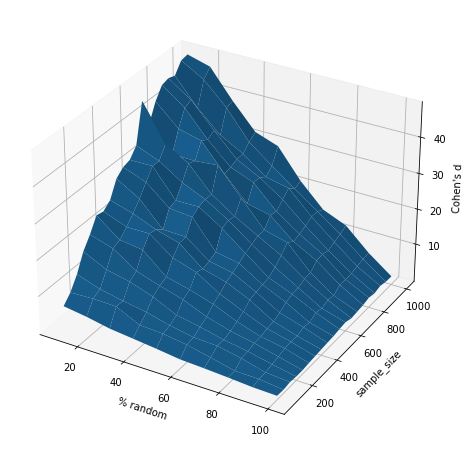

In [129]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

x,y = np.meshgrid(list(range(10,101,10)), np.array(sizes))
ax.plot_surface(x, y, np.abs(d_values))
ax.set_ylabel("sample_size")
ax.set_xlabel("% random")
ax.set_zlabel("Cohen's d")

plt.show()

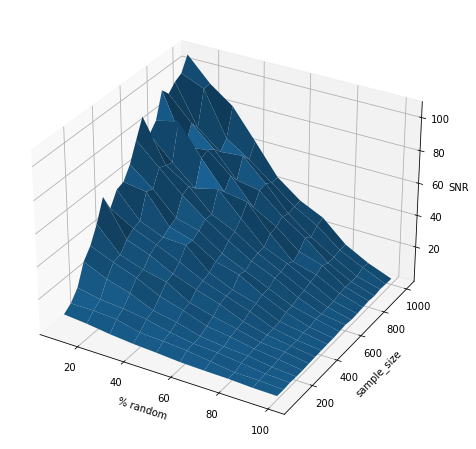

In [130]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

x,y = np.meshgrid(list(range(10,101,10)), np.array(sizes))
ax.plot_surface(x, y, snr_values)
ax.set_ylabel("sample_size")
ax.set_xlabel("% random")
ax.set_zlabel("SNR")

plt.show()

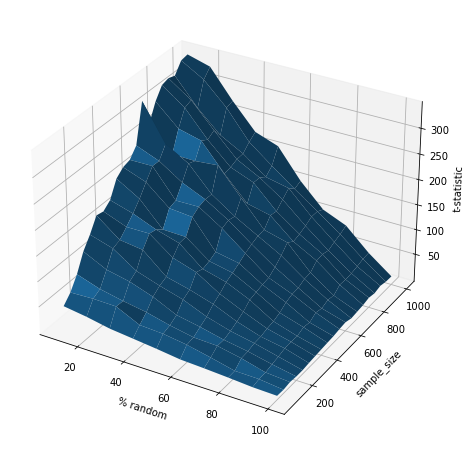

In [132]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

x,y = np.meshgrid(list(range(10,101,10)), np.array(sizes))
ax.plot_surface(x, y, np.abs(t_values))
ax.set_ylabel("sample_size")
ax.set_xlabel("% random")
ax.set_zlabel("t-statistic")

plt.show()

# Changing iteration size?

In [135]:
ITERATION_NUMBER = 1000

# sizes = list(range(50,1001,50))
sizes = [200]
snr_values = np.zeros((len(sizes), 10))
t_values = np.zeros((len(sizes), 10))
d_values = np.zeros((len(sizes), 10))


for index2, SAMPLE_SIZE in enumerate(sizes):
    print(f"\nSAMPLE_SIZE={SAMPLE_SIZE}")
    random_sizes = list(range(0,SAMPLE_SIZE,SAMPLE_SIZE//10))

    mean_distance_random = np.zeros((len(random_sizes)))
    mean_distance_test = np.zeros((len(random_sizes)))

    var_distance_random = np.zeros((len(random_sizes)))
    var_distance_test = np.zeros((len(random_sizes)))

    for index, random_size in enumerate(random_sizes):
        distances_random = []
        distances_test = []

        means = np.zeros((ITERATION_NUMBER, 9))
        
        for i in range(0, ITERATION_NUMBER):
            sample_random = createSamples(SAMPLE_SIZE,radix)
            sample_random2 = createSamples(SAMPLE_SIZE,radix)

            if random_size == 0:
                sample_test = sample_3k[:SAMPLE_SIZE]
            else:
                # mixing up with random data
                sample_random3 = createSamples(random_size,radix)
                sample_test = np.concatenate((sample_random3, sample_3k[:(SAMPLE_SIZE-random_size)]))

            distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
            distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

            # means[i] = np.mean(sample_test, axis=0)
            means[i] = scipy.stats.mode(sample_test, axis=0)[0]
            
            distances_random.append(distance_random)
            distances_test.append(distance_test)

        res = scipy.stats.ttest_ind(distances_random, distances_test, equal_var=False)
        snr = (np.mean(distances_test)-np.mean(distances_random)) / np.std(distances_random)
        d = cohen_d(distances_random, distances_test)
        print(f"random_size = {random_size}: SNR: {snr} \tt-stat: {res[0]} \tcohens-d: {d} \tp-value (two-sided test): {res[1]}")

        # store the values
        snr_values[index2][index] = snr
        t_values[index2][index] = res[0]
        d_values[index2][index] = d


SAMPLE_SIZE=200
random_size = 0: SNR: 27.981632214652752 	t-stat: -358.56531521285797 	cohens-d: -16.0355283837918 	p-value (two-sided test): 0.0
random_size = 20: SNR: 22.972460636516274 	t-stat: -325.24099826339557 	cohens-d: -14.545219623736871 	p-value (two-sided test): 0.0
random_size = 40: SNR: 18.649929865829726 	t-stat: -267.24397335483206 	cohens-d: -11.951513819970941 	p-value (two-sided test): 0.0
random_size = 60: SNR: 14.032383633706509 	t-stat: -217.82176278501134 	cohens-d: -9.741285371322386 	p-value (two-sided test): 0.0
random_size = 80: SNR: 10.65451480448982 	t-stat: -175.16004667954238 	cohens-d: -7.833395426349861 	p-value (two-sided test): 0.0
random_size = 100: SNR: 7.293056511666486 	t-stat: -126.69036688799227 	cohens-d: -5.665765449118784 	p-value (two-sided test): 0.0
random_size = 120: SNR: 5.655037681875962 	t-stat: -101.09444513886665 	cohens-d: -4.521081029562579 	p-value (two-sided test): 0.0
random_size = 140: SNR: 3.9216043509689067 	t-stat: -76.5370

# END